In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pydub import AudioSegment
from scipy.io import wavfile
from scipy.fft import fft, ifft

### Metodo da Sobreposição e Soma 

Função que implementa o metodo da sobreposição e soma

In [17]:
def overlap_add_convolution(x, h, L):
    """
    Convolução Sobreposição e Soma (Overlap-Add).
    
    Args:
    x (numpy array): Sinal de entrada.
    h (numpy array): Resposta ao impulso do filtro.
    L (int): Comprimento do bloco para FFT.

    Returns:
    numpy array: Resultado da convolução.
    """
    M = len(h)
    N = L + M - 1  # Comprimento da FFT (bloco + filtro - 1)

    # Zero padding do filtro para tamanho N
    h_padded = np.zeros(N)
    h_padded[:M] = h

    # FFT do filtro
    H = fft(h_padded)

    # Número de blocos completos e um bloco parcial, se necessário
    num_blocks = int(np.ceil(len(x) / L))
    result = np.zeros(num_blocks * L + M - 1)

    for i in range(num_blocks):
        # Extrai o bloco atual do sinal
        block = x[i*L : min((i+1)*L, len(x))]

        # Zero padding do bloco para tamanho N
        block_padded = np.zeros(N)
        block_padded[:len(block)] = block

        # FFT do bloco
        Block = fft(block_padded)

        # Convolução no domínio da frequência
        Y = Block * H

        # IFFT para obter a convolução no domínio do tempo
        y = ifft(Y)

        # Sobreposição e Soma
        result[i*L : i*L+N] += np.real(y)

    
    return result

### Passo 1

implemenção do algoritmo de convolução escolhido (overlap-add) e validação com sinais aleatórios para entrada x[n] e para o filtro FIR h[n]

Parâmetros definidos:

- L = N - M + 1
- M = 150
- FFT com 512 pontos
- Comprimento do sinal de entrada = 15,3*L

O algoritmo implementado no passo anterior deve ser validado comparando o resultado de saída do processamento com o resultado de uma convolução no tempo entre o sinal de entrada x[n] e o filtro h[n] escolhidos.

In [3]:
L = 512  # Comprimento do bloco para FFT
M = 150  # Comprimento do filtro

Gerando x(n) e h(n) aleatórios:

In [4]:
x = np.random.randn(int(15.3 * L))  # Sinal de entrada
h = np.random.randn(M) # Resposta ao impulso do filtro

Aplicando a convolução direta:

In [5]:
y_direct = np.convolve(x, h)

Aplicando a convolução overlap-add:

In [6]:
y_overlap_add = overlap_add_convolution(x, h, L)

### Resultados

Plotando os resultados das duas convoluções para comparações.

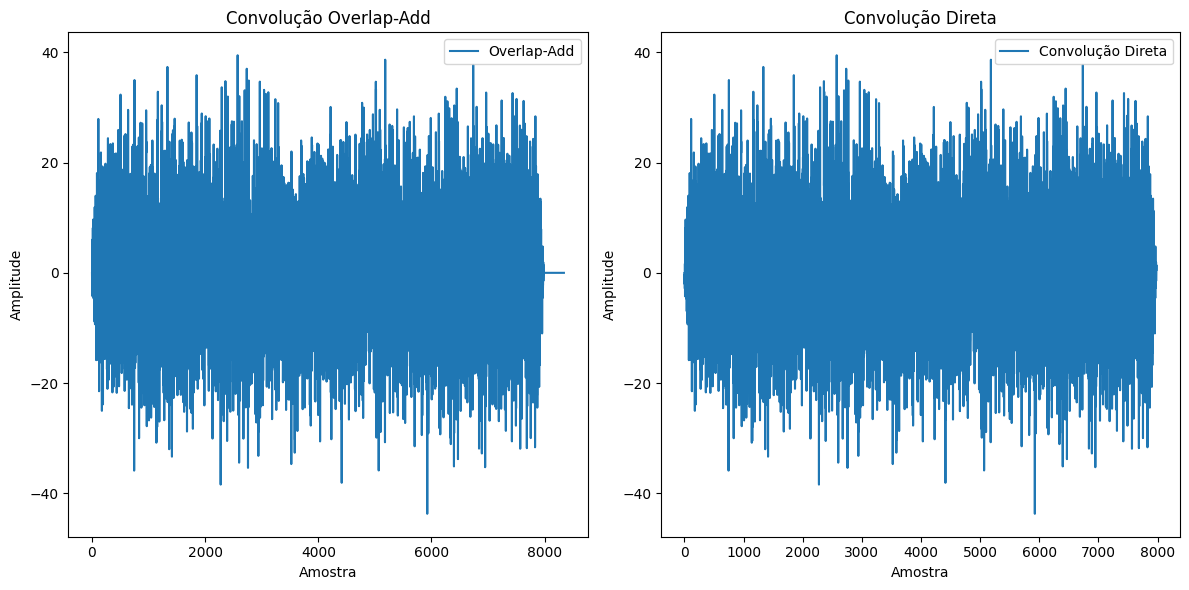

In [19]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(y_overlap_add, label='Overlap-Add')
plt.title("Convolução Overlap-Add")
plt.xlabel("Amostra")
plt.ylabel("Amplitude")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(y_direct, label='Convolução Direta')
plt.title("Convolução Direta")
plt.xlabel("Amostra")
plt.ylabel("Amplitude")
plt.legend()

plt.tight_layout()
plt.savefig('overlap_add_convolution_x_direct_convolution.png')


Podemos observar que obtemos o mesmo resultado com a convolução implementada.

Validado! 

### Passo 2

- Utilizar um sinal de voz com duração mínima de 10 segundos.

- Aplicar o mesmo ruido utilizado nos projetos da UII.

- Utilizar o mesmo filtro FIR projetado anteriormente, no projeto de 
filtragem de voz desenvolvido na UII. 

- Aplicar a overlap-add implementada com o Filtro FIR e o sinal de voz 

In [61]:
# Lendo o sinal de voz gravado
fs, audio_original = wavfile.read('audio_original.wav')
t = np.arange(len(audio_original)) / fs

Parametros definidos na UII:

In [62]:
a1, a2 = 5, 5  # Amplitudes do ruído
f1, f2 = 5700, 6000  # Frequências do ruído

Definição do ruido e aplicação do mesmo no audio

In [63]:
ruido = a1 * np.cos(2 * np.pi * f1 * t) + a2 * np.cos(2 * np.pi * f2 * t)

audio_ruidoso = audio_original.flatten() + ruido

Salvando o Audio ruidoso:

In [64]:
audio_norm = (audio_ruidoso / np.max(np.abs(audio_ruidoso)) * 32767).astype(np.int16)

# Criar o objeto AudioSegment
audio_segment = AudioSegment(
    audio_norm.tobytes(), 
    frame_rate=fs, 
    sample_width=audio_norm.dtype.itemsize, 
    channels=1
)

# Salvar o arquivo em formato MP3
audio_segment.export("audio_ruidoso.mp3", format="mp3")

<_io.BufferedRandom name='audio_ruidoso.mp3'>

Definindo a resposta ao impulso do filtro:

In [65]:
def hn(n):
    return (np.sin(0.025 * np.pi) * (n - 13)) / (13 * np.pi)  # Resposta ao impulso do filtro

n = np.arange(len(audio_ruidoso))

h = hn(n)

Aplicando a overlap-add convolution entre o sinal de voz gravado e o filtro projetado:

In [66]:
audio_filtrado = overlap_add_convolution(audio_ruidoso, h, L)

In [67]:
# Tirando o atraso resultate da convolução
atraso = int(len(audio_filtrado) / 2)
audio_filtrado_sem_atraso = audio_filtrado[atraso:]

Salvando o Audio filtrado:

In [37]:
audio_norm = (audio_filtrado_sem_atraso / np.max(np.abs(audio_filtrado_sem_atraso)) * 32767).astype(np.int16)

# Criar o objeto AudioSegment
audio_segment = AudioSegment(
    audio_norm.tobytes(), 
    frame_rate=fs, 
    sample_width=audio_norm.dtype.itemsize, 
    channels=1
)

# Salvar o arquivo em formato MP3
audio_segment.export("audio_filtrado.mp3", format="mp3")

<_io.BufferedRandom name='audio_filtrado.mp3'>

### Resultados

Plotando o sinal original, ruidoso e filtrado atravez da overlap-add convolution (Dominio da frequencia):

In [68]:
# Encontrando o menor comprimento entre os sinais
min_length = min(len(audio_original), len(audio_ruidoso), len(audio_filtrado_sem_atraso))

# Reduzindo todos os sinais ao menor comprimento encontrado
audio_original_ = audio_original[:min_length]
audio_ruidoso_ = audio_ruidoso[:min_length]
audio_filtrado_ = audio_filtrado_sem_atraso[:min_length]

# Calculando FFTs
fft_original = np.fft.fft(audio_original_)
fft_ruidoso = np.fft.fft(audio_ruidoso_)
fft_filtrado = np.fft.fft(audio_filtrado_)

# Calculando frequências
# N = len(audio_filtrado_sem_atraso)
freqs = np.fft.fftfreq(min_length, 1 / fs)

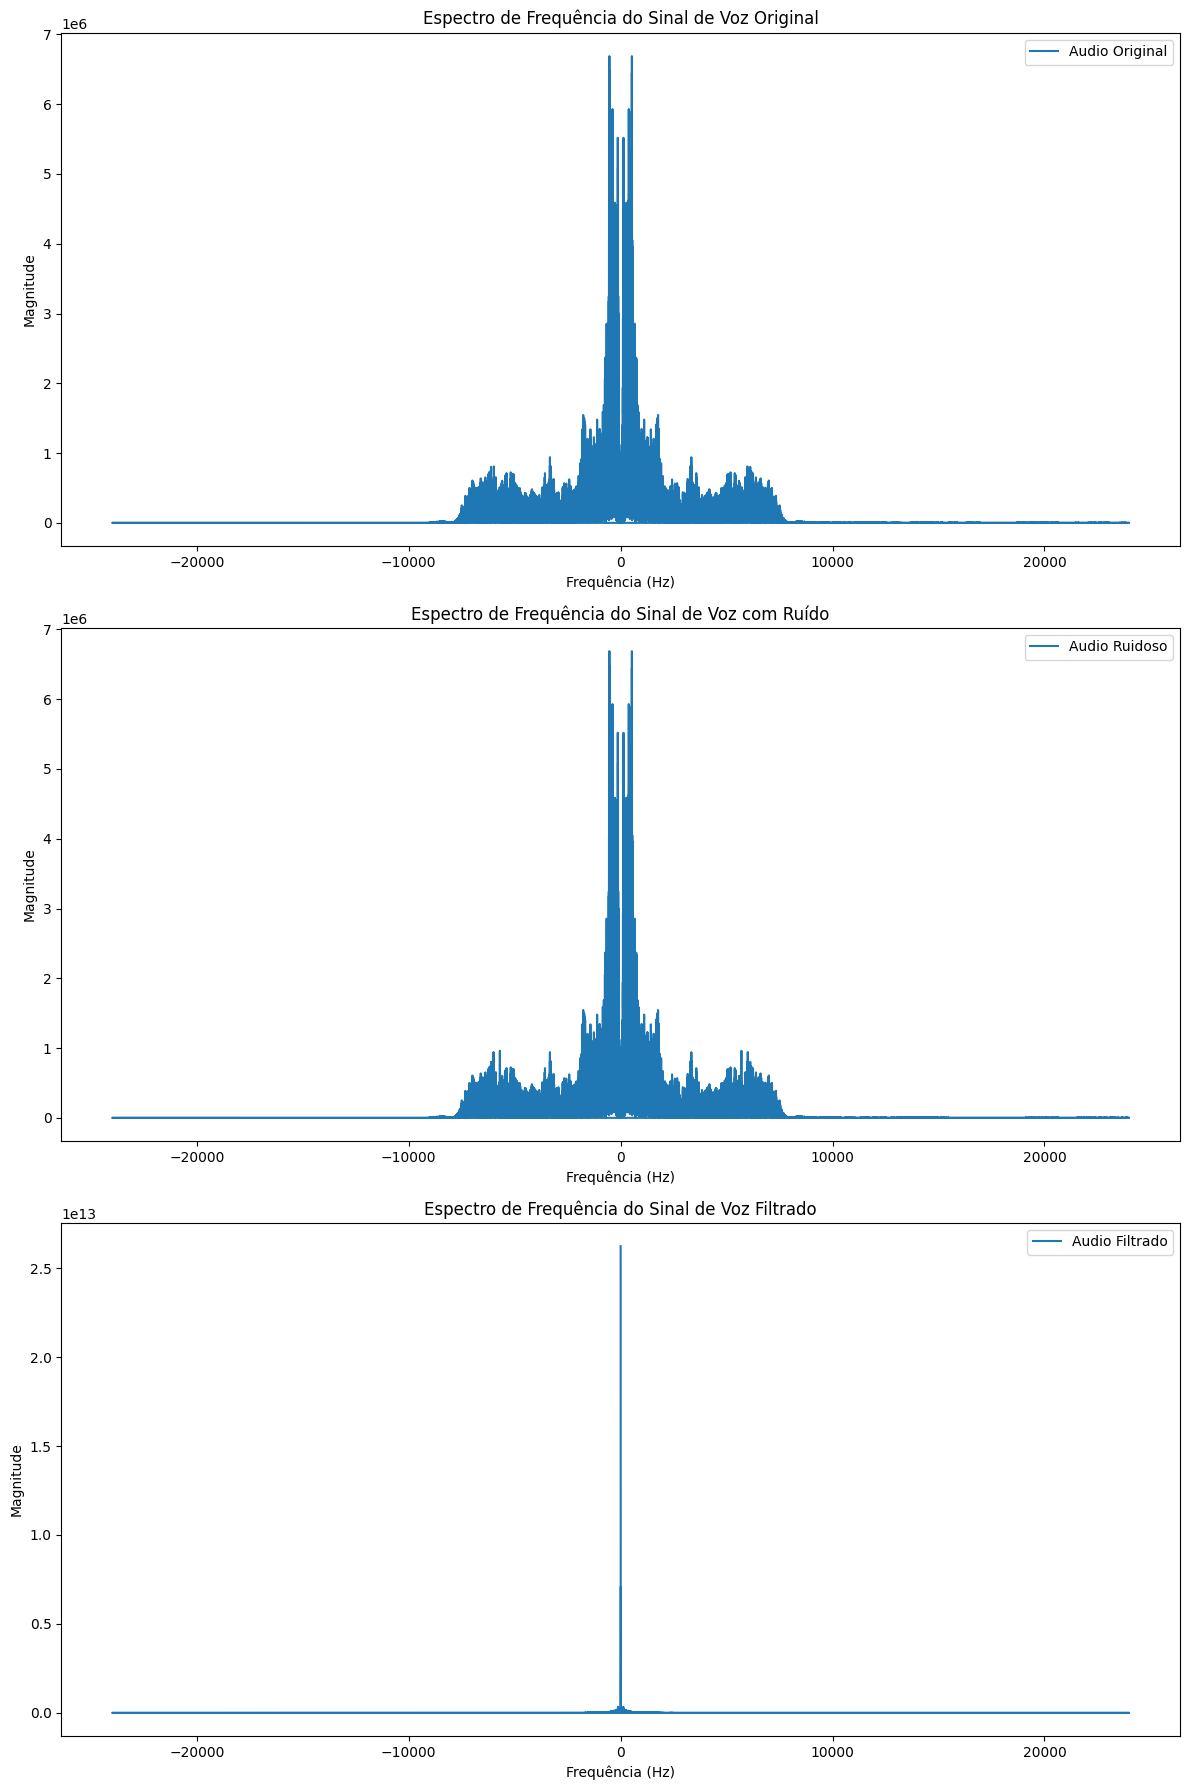

In [70]:
plt.figure(figsize=(12, 18))

# Sinal Original
plt.subplot(3, 1, 1)
plt.plot(freqs, np.abs(fft_original), label='Audio Original')
plt.title("Espectro de Frequência do Sinal de Voz Original")
plt.xlabel("Frequência (Hz)")
plt.ylabel("Magnitude")
plt.legend()

# Sinal com Ruído
plt.subplot(3, 1, 2)
plt.plot(freqs, np.abs(fft_ruidoso), label='Audio Ruidoso')
plt.title("Espectro de Frequência do Sinal de Voz com Ruído")
plt.xlabel("Frequência (Hz)")
plt.ylabel("Magnitude")
plt.legend()

# Sinal Filtrado
plt.subplot(3, 1, 3)
plt.plot(freqs, np.abs(fft_filtrado), label='Audio Filtrado')
plt.title("Espectro de Frequência do Sinal de Voz Filtrado")
plt.xlabel("Frequência (Hz)")
plt.ylabel("Magnitude")
plt.legend()

plt.tight_layout()
plt.savefig('Comparativo_sinal_original_ruidoso_filtrado.png')
